# Examples

> Example applications

In [ ]:
#| default_exp waveforms

In [ ]:
#| hide
#| export
from nbdev.showdoc import *
import numpy as np
from scipy.optimize import minimize

from matplotlib import pyplot as plt
import seaborn as sns
import time

In [ ]:
#|hide
from wavewriter import *

In [ ]:
#|hide
sns.set()
sns.set_context('talk')
sns.set_style('ticks')

In [ ]:
#|hide
#|eval: false
device = WaveWriter()

Exception: Device not found

## Plotting waveforms

In [ ]:
#| export
def plot_waveforms(t, v):
    '''
    Generate waveform plot
    Simulate effect of sending to DAC
    
    For every point after first: duplicate previous amplitude value at new timepoint
    This allows simulating step change at each timepoint
    '''
    new_v = [0, 0, v[0]]
    new_t = [-50, t[0], t[0]]
    
    for idx, v_ in enumerate(v[1:]):
        # Add old value at new timepoint
        new_v.append(new_v[-1])
        new_t.append(t[idx+1])
        
        # Add new value at new timepoint
        new_v.append(v_)
        new_t.append(t[idx+1])
        
    # Plot figures
    fig, ax = plt.subplots()
    ax.plot(new_t, new_v, 'k.')
    ax.plot(new_t, new_v, 'k')
    
    ax.set(
        xlabel = 'Time ($\mu$s)',
        ylabel = 'Amplitude (mA)'
    )
    
    sns.despine(offset = 10, trim=True)

## Converting waveforms

In [ ]:
# Convert waveform
def convert_waveform(v, t):
    '''
    Convert waveform into format ready to be sent to device
    '''
    # Convert to arrays
    v = np.array(v)
    t = np.array(t)
    
    # Convert to range 0 - 4096 from -50 to 50
    v = ((v+50) / 100) * 4096
    v = v.astype(int)
    
    t = t.astype(int)
    
    return v, t

## Square waveforms

### Tonic stimulation

In [ ]:
#| export
# Generate tonic stimulation waveform
def generate_tonic(
    amplitude: float, # Amplitude of square wave; mA
    frequency: int, # Number of square waves per second; Hz
    pulsewidth: int, # Width of pulses; us
    biphasic: bool = True # Whether to include charge balancing phase; bool
) -> (np.ndarray, np.ndarray):
    '''
    Generate tonic square wave stimulation
    Args:
        amplitude: float; amplitude of square waves (mA)
        frequency: int; number of square waves per second (Hz)
        pulsewidth: int; width of pulses (us)
        biphasic: bool, default True; whether pulses should have biphasic component
    Returns:
        v: ndarray; output at each timepoint (mA)
        t: ndarray; correspondong timepoints (us)
    '''
    # Start with stimulation on at t=0
    v = [amplitude]
    t = [0]
    
    # Get period between pulses
    period = 1000000 / frequency # Period in microseconds
    
    # Get interval between pulses
    if biphasic == True:
        interval = period - (pulsewidth * 2)
    else:
        interval = period - pulsewidth
        
    # Generate five pulses (repeating):
    for pulse in range (5):
        # If not first: start pulse after interval
        if pulse != 0:
            v.append(amplitude)
            t.append(t[-1])
            
        # If biphasic: add biphasic pulse then stop
        if biphasic == True:
            # Add negative phase
            v.append(-amplitude)
            t.append(t[-1] + pulsewidth)
            
        # End stimulation
        v.append(0)
        t.append(t[-1] + pulsewidth)
        
        # Add interval before next pulse
        v.append(0)
        t.append(t[-1] + interval)
        
    return v, t

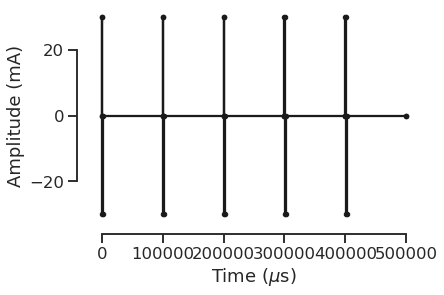

In [ ]:
# Generate tonic pulse train
v, t = generate_tonic(
    30, # mA
    10, # Hz
    1000, # us
    biphasic = True
)

plot_waveforms(t, v)

In [ ]:
# Send to device
v_, t_ = convert_waveform(v, t)
device.send_waveform(v_, t_)
device.start()
time.sleep(50)
device.stop()

KeyboardInterrupt: 

### High frequency

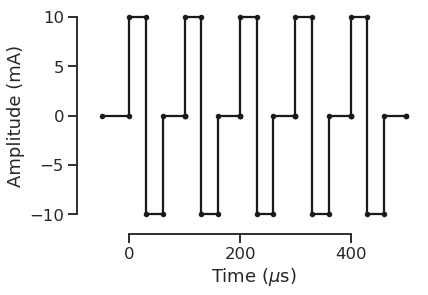

In [ ]:
# Generate high frequency tonic stimulation
v, t = generate_tonic(
    10, # mA
    10000, # Hz
    30, # mA
    biphasic=True
)

plot_waveforms(t, v)

In [ ]:
# Send to device
v_, t_ = convert_waveform(v, t)
device.send_waveform(v_, t_)
device.start()
time.sleep(15)
device.stop()

### Burst (Boston)

In [ ]:
#| export
# Generate Boston burst waveform
def generate_burst_boston(
    amplitude: float, # Amplitude of burst; mA
    numpulses: int, # Number of pulses in burst
    intraburst: int, # Frequency of pulses in burst; Hz
    interburst: int, # Frequency of bursts; Hz
    pulsewidth: int # Width of pulses in burst; us
) -> (np.ndarray, np.ndarray):
    '''
    Generate Boston burst waveform
    Args:
        amplitude: float; amplitude of burst (mA)
        numpulses: int; number of pulses in burst
        intraburst: int; frequency of pulses within burst (Hz)
        interburst: int; frequency of bursts (Hz)
        pulsewidth: int; width of pulses (us)
    Returns:
        v: ndarray; output at each timepoint (mA)
        t: ndarray; corresponding timepoints (us)
    '''
    # Create lists; start stimulation at t=0
    v = [amplitude]
    t = [0]
    
    # Get period and interval between pulses
    period_intra = 1000000 / intraburst # Period in microseconds
    interval_intra = period_intra - (pulsewidth * 2)
    
    # Get period and interval between bursts
    burst_duration = ((pulsewidth * 2) + interval_intra) * numpulses
    period_inter = 1000000 / interburst
    interval_inter = period_inter - burst_duration
    
    # Generate three bursts
    for burst in range (3):
        # Generate pulses
        for pulse in range(numpulses):
            # Start stimulation
            v.append(amplitude)
            t.append(t[-1])
            
            # Add biphasic pulse
            v.append(-amplitude)
            t.append(t[-1] + pulsewidth)
            
            # End stimulation pulse
            v.append(0)
            t.append(t[-1] + pulsewidth)
            
            # Add interval before next pulse
            v.append(0)
            t.append(t[-1] + interval_intra)
            
        # Add interval before next burst
        v.append(0)
        t.append(t[-1] + interval_inter)
        
    return v, t

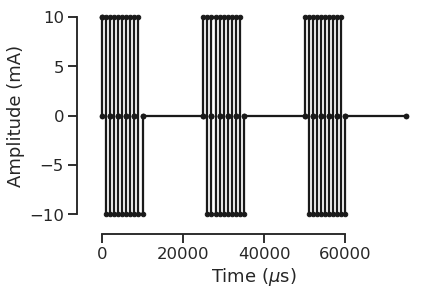

In [ ]:
# Generate Boston burst waveform
v, t = generate_burst_boston(
    10, # mA
    5, # pulses per burst
    500, # Hz intraburst
    40, # Hz interburst
    1000 # us pulsewidth
)

plot_waveforms(t, v)

In [ ]:
# Send to device
v_, t_ = convert_waveform(v, t)
device.send_waveform(v_, t_)
device.start()
time.sleep(15)
device.stop()

### Burst (Abbott)

In [ ]:
#| export
#| hide
# a set to amplitude / 2; k determined numerically
def exponential_decay(x, a, k):
    return a * np.exp(-k * x)

# Objective function: find k s.t. AUC exponential = AUC pulses
def objective(k, x, a, target):
    auc_recovery = np.abs(np.sum(exponential_decay(x,a,k))) 
    val = np.abs(auc_recovery - target)
    return val

In [ ]:
#| export
# Generate Abbott burst waveform
def generate_burst_abbott(
    amplitude: float, # Amplitude of burst; mA
    intraburst: int, # Frequency of pulses within burst; Hz
    interburst: int, # Frequency of bursts; Hz
    pulsewidth: int # Width of pulses within burst (us)
) -> (np.ndarray, np.ndarray):
    '''
    Generate Abbott burst waveform
    Args:
        amplitude: float; amplitude of burst (mA)
        intraburst: int; frequency of pulses within burst (Hz)
        interburst: int; frequency of bursts (Hz)
        pulsewidth: int; width of pulses (us)
    Returns:
        v: ndarray; output at each timepoint (mA)
        t: ndarray; corresponding timepoints (us)
    '''
    # Create lists; start stimulation at t=0
    v = [amplitude]
    t = [0]
    
    # Get period + interval between pulses
    period_intra = 1000000 / intraburst # Period in microseconds
    interval_intra = period_intra - pulsewidth
    
    # Get period + interval between bursts
    burst_duration = (pulsewidth + interval_intra) * 5
    period_inter = 1000000 / interburst
    interval_inter = period_inter - burst_duration
    
    # Generate pulses
    for pulse in range(4):
        # Start stimulation
        v.append(amplitude)
        t.append(t[-1])
        
        # End stimulation pulse
        v.append(0)
        t.append(t[-1] + pulsewidth)
        
        # Add interval before next pulse
        v.append(0)
        t.append(t[-1] + interval_intra)
        
    # Add last pulse - no interval after
    v.append(amplitude)
    t.append(t[-1])
    
    v.append(0)
    t.append(t[-1] + pulsewidth)
    
    # Add recovery phase
    t_ = np.linspace(0, 5000, num=500)
    t_recovery = np.linspace(t[-1], t[-1] + 5000, num=500)
    
    # Get value to recover
    target = amplitude * pulsewidth * 5
    
    # Optimise parameters to match this 
    x0 = 0.001
    res = minimize(objective, x0,
                  method='nelder-mead',
                  args=(t_, -amplitude/2, target)
                  )
    
    # Get optimal value
    k = res.x
    
    # Get exponential recovery
    v_recovery = exponential_decay(t_, -amplitude/2, -res.x)
    
    # Add to values
    for idx, val in enumerate(v_recovery):
        v.append(val)
        t.append(t_recovery[idx])
        
    # Add interval before next burst
    v.append(0)
    t.append(t[0] + period_inter)
    
    return v, t

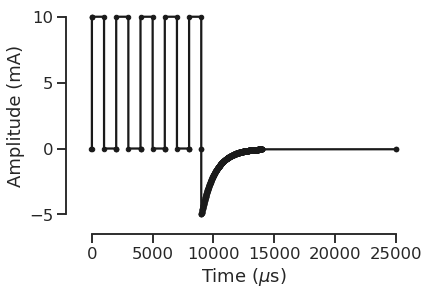

In [ ]:
# Generate Abbott burst waveform
v, t = generate_burst_abbott(
    10, # mA
    500, # Hz intraburst
    40, # Hz interburst
    1000, # us pulsewidth
)

plot_waveforms(t, v)

In [ ]:
# Send to device
v_, t_ = convert_waveform(v, t)
device.send_waveform(v_, t_)
device.start()
time.sleep(15)
device.stop()

## Sinusoidal waveforms

### Sinusoid

In [ ]:
# Generate sinusoidal waveform
def generate_sine(
    amplitude: float, # Amplitude of sine wave
    frequency: int, # Frequency of sine wave
    numcycles: int # Number of cycles to generate
) -> (np.ndarray, np.ndarray):
    '''
    Generate sinusoidal waveform
    Args:
        amplitude: float; maximal amplitude
        frequency: int; frequency of sinusoid
        numcycles: int; number of cycles to generate
    Returns:
        v: ndarray; output at each timepoint (mA)
        t: ndarray; corresponding timepoints (us)
    '''
    # Get period for one cycle
    period = 1 / frequency
    
    # Get time
    t = np.linspace(0, period*numcycles, num=25*numcycles)
    
    # Get sinusoid
    v = np.sin(2 * np.pi * frequency * t) * amplitude
    
    # Convert time to microseconds
    t = t * 1000000
    
    return v, t

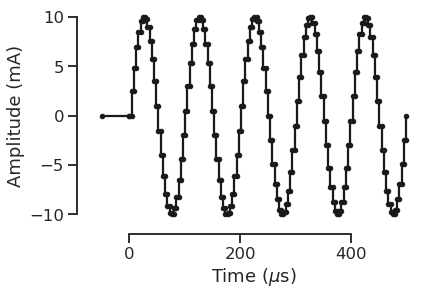

In [ ]:
# Generate sinusoidal stimulation
v, t = generate_sine(
    10, # mA
    10000, # Hz
    5 # Cycles
)

plot_waveforms(t, v)

In [ ]:
# Send to device
v_, t_ = convert_waveform(v, t)
device.send_waveform(v_, t_)
device.start()
time.sleep(15)
device.stop()

### Square-modulated sinusoid (Russian)

In [ ]:
# Generate Russian waveform
def generate_russian(
    amplitude: float, # Amplitude of sinusoid; mA
    frequency_sine: int, # Frequency of sinusoid; Hz
    frequency_square: int, # Frequency of modulating square wave; Hz
    pulsewidth_square: int # Width of modulating square wave; us
) -> (np.ndarray, np.ndarray):
    '''
    Generate Russian waveform
    Sinusoidal waveform modulated by square waves
    Args:
        amplitude: float; amplitude of sinusoid (mA)
        frequency_sine: int; frequency of sinusoid (Hz)
        frequency_square: int; frequency of modulating square wave (Hz)
        pulsewidth_square: int; width of modulating square wave (us)
    Returns:
        v: ndarray; output at each timepoint (mA)
        t: ndarray; corresponding timepoints (us)
    '''
    # Get period and interval
    period_square = 1000000 / frequency_square
    interval_square = period_square - pulsewidth_square
    
    # Get cycles per window
    cycles_per_window = frequency_sine / frequency_square
    
    # Get time
    t = np.linspace(0, pulsewidth_square/1000000, num=int(cycles_per_window*25))
    
    # Get sinusoid
    v = np.sin(2 * np.pi * frequency_sine * t) * amplitude
    
    # Convert time to microseconds
    t = t * 1000000
    
    # Convert to lists
    v = v.tolist()
    t = t.tolist()
    
    # Add interval
    v.append(0)
    t.append(t[-1])
    v.append(0)
    t.append(t[-1] + interval_square)
    
    return v, t

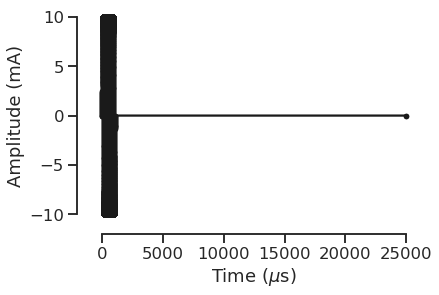

In [ ]:
# Generate Russian waveform
v, t = generate_russian(
    10, # mA
    5000, # Hz
    40, # Hz (modulating)
    1000 # us
)

plot_waveforms(t, v)

In [ ]:
# Send to device
v_, t_ = convert_waveform(v, t)
device.send_waveform(v_, t_)
device.start()
time.sleep(15)
device.stop()

### Gaussian-modulated sinusoid (Wavelet)

### Sinusoid-modulated wavelet

In [ ]:
#|eval: false
v = np.array([0, 2000, 0, 4000, 0])
t = np.array([0, 25000, 25100, 50000, 50100])

device.send_waveform(v, t)

device.start()
time.sleep(50)
device.stop()

In [ ]:
#|echo:false
v_ = [v[0]]
t_ = [t[0]]

for idx, val in enumerate(v[1:]):
    v_.append(v[idx-1])
    t_.append(t[idx])
    v_.append(v[idx])
    t_.append(t[idx])
    
for _ in range(2):
    t_.extend(t_ + t_[-1])
    v_.extend(v_)

for idx, val in enumerate(t_):
    t_[idx] = val/1000

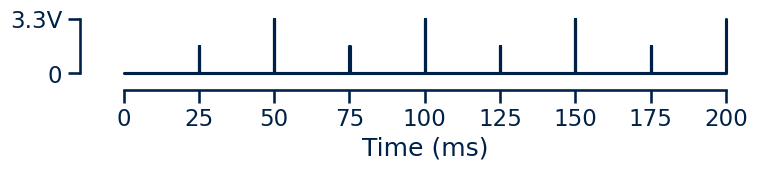

In [ ]:
#|echo:false
#|classes: light-mode

bg_colour = '#fff'
line_colour = '#002147'

fig, ax = plt.subplots(figsize=(8,2))

ax.plot(t_, v_, color=line_colour)

ax.set(
    yticks = (0, np.max(v)),
    yticklabels = ['0', '3.3V'],
    #xlim = (0, 0.5),
    xlabel = 'Time (ms)'
)

sns.despine(ax=ax, offset=10, trim=True)

ax.xaxis.label.set_color(line_colour)
ax.yaxis.label.set_color(line_colour)
    
ax.tick_params(axis='x', colors=line_colour)
ax.tick_params(axis='y', colors=line_colour)
    
ax.spines['left'].set_color(line_colour)
ax.spines['bottom'].set_color(line_colour)
    
ax.set_facecolor(bg_colour)
fig.patch.set_facecolor(bg_colour)

fig.tight_layout()
fig.savefig('tonic.png')

### Tonic stimulation

In [ ]:
v = np.array([4000, 0, 4000, 0, 4000, 0, 0])
t = np.array([0, 500, 1000, 1500, 2000, 2500, 3000])

device.send_waveform(v, t)

device.start()
time.sleep(3)
device.stop()

In [ ]:
#|echo:false
v_ = [v[0]]
t_ = [t[0]]

for idx, val in enumerate(v[1:]):
    v_.append(v[idx-1])
    t_.append(t[idx])
    v_.append(v[idx])
    t_.append(t[idx])
    
for _ in range(2):
    t_.extend(t_ + t_[-1])
    v_.extend(v_)

for idx, val in enumerate(t_):
    t_[idx] = val/1000

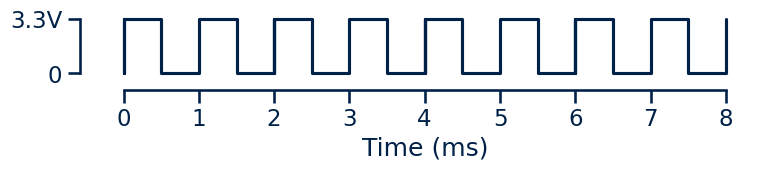

In [ ]:
#|echo:false
#|classes: light-mode

bg_colour = '#fff'
line_colour = '#002147'

fig, ax = plt.subplots(figsize=(8,2))

ax.plot(t_, v_, color=line_colour)

ax.set(
    yticks = (0, np.max(v)),
    yticklabels = ['0', '3.3V'],
    #xlim = (0, 0.5),
    xlabel = 'Time (ms)'
)

sns.despine(ax=ax, offset=10, trim=True)

ax.xaxis.label.set_color(line_colour)
ax.yaxis.label.set_color(line_colour)
    
ax.tick_params(axis='x', colors=line_colour)
ax.tick_params(axis='y', colors=line_colour)
    
ax.spines['left'].set_color(line_colour)
ax.spines['bottom'].set_color(line_colour)
    
ax.set_facecolor(bg_colour)
fig.patch.set_facecolor(bg_colour)

fig.tight_layout()
fig.savefig('highfreq.png')

### High frequency stimulation

### Burst stimulation

In [ ]:
v = np.array([0, 4000, 0, 4000, 0, 4000, 0, 4000, 0, 4000, 0, 0])
t = np.array([0, 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 24900])

In [ ]:
v = np.array([0, 0, 
              4000, 4000, 
              0, 0, 
              4000, 4000, 
              0, 0, 
              4000, 4000, 
              0, 0,
              4000, 4000,
              0, 0,
              4000, 4000,
              0, 0
             ])

t = np.array([0, 100,
              100, 1100,
              1100, 2100,
              2100, 3100,
              3100, 4100,
              4100, 5100,
              5100, 6100,
              6100, 7100,
              7100, 8100,
              8100, 9100,
              9100, 24900
             ])
    

In [ ]:
device.send_waveform(v, t)

device.start()
time.sleep(3)
device.stop()

In [ ]:
#|echo:false
v_ = np.array([0])
t_ = np.array([0])

for _ in range(3):
    v_ = np.concatenate((v_, v))
    t_ = np.concatenate((t_, t+t_[-1]))

t_ = t_/1000

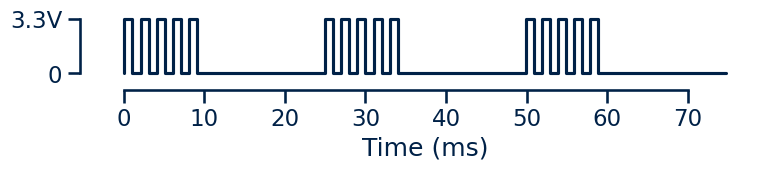

In [ ]:
#|echo:false
#|classes: light-mode

bg_colour = '#fff'
line_colour = '#002147'

fig, ax = plt.subplots(figsize=(8,2))

ax.plot(t_, v_, color=line_colour)

ax.set(
    yticks = (0, np.max(v)),
    yticklabels = ['0', '3.3V'],
    #xlim = (0, 0.5),
    xlabel = 'Time (ms)'
)

sns.despine(ax=ax, offset=10, trim=True)

ax.xaxis.label.set_color(line_colour)
ax.yaxis.label.set_color(line_colour)
    
ax.tick_params(axis='x', colors=line_colour)
ax.tick_params(axis='y', colors=line_colour)
    
ax.spines['left'].set_color(line_colour)
ax.spines['bottom'].set_color(line_colour)
    
ax.set_facecolor(bg_colour)
fig.patch.set_facecolor(bg_colour)

fig.tight_layout()
fig.savefig('burst.png')

## Arbitrary waveforms

In [ ]:
v = np.concatenate((np.linspace(0, 2000, 50), np.linspace(2000, 0, 50))).astype(int)
t = np.linspace(0, 100000, 100).astype(int)

device.send_waveform(v, t)

device.start()
time.sleep(3)
device.stop()

In [ ]:
#|echo:false
v_ = np.array([0])
t_ = np.array([0])

for _ in range(3):
    v_ = np.concatenate((v_, v))
    t_ = np.concatenate((t_, t+t_[-1]))

t_ = t_/1000

### Sawtooth stimulation

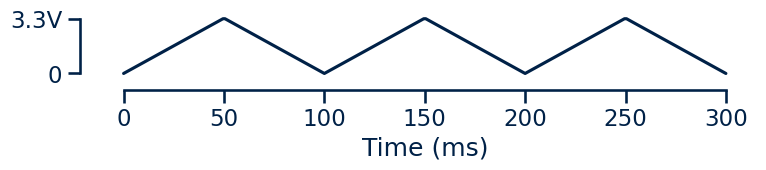

In [ ]:
#|echo:false
#|classes: light-mode

bg_colour = '#fff'
line_colour = '#002147'

fig, ax = plt.subplots(figsize=(8,2))

ax.plot(t_, v_, color=line_colour)

ax.set(
    yticks = (0, np.max(v)),
    yticklabels = ['0', '3.3V'],
    #xlim = (0, 0.5),
    xlabel = 'Time (ms)'
)

sns.despine(ax=ax, offset=10, trim=True)

ax.xaxis.label.set_color(line_colour)
ax.yaxis.label.set_color(line_colour)
    
ax.tick_params(axis='x', colors=line_colour)
ax.tick_params(axis='y', colors=line_colour)
    
ax.spines['left'].set_color(line_colour)
ax.spines['bottom'].set_color(line_colour)
    
ax.set_facecolor(bg_colour)
fig.patch.set_facecolor(bg_colour)

fig.tight_layout()
fig.savefig('triangle.png')

### Sinusoidal stimulation

In [ ]:
T = 1
fs = 4000
t = np.linspace(0, T, T*fs, endpoint=False)

f = 100
v = np.sin(2 * np.pi * f * t) * 4000

In [ ]:
t_ = t * 1000000
t_ = t_[:40].astype(int)
v_ = v[:40].astype(int)

In [ ]:
device.send_waveform(v_, t_)

device.start()
time.sleep(3)
device.stop()

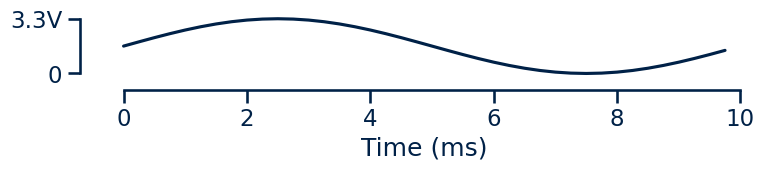

In [ ]:
#|echo:false
#|classes: light-mode

bg_colour = '#fff'
line_colour = '#002147'

fig, ax = plt.subplots(figsize=(8,2))

ax.plot(t_/1000, v_, color=line_colour)

ax.set(
    yticks = (np.min(v), np.max(v)),
    yticklabels = ['0', '3.3V'],
    #xlim = (0, 0.5),
    xlabel = 'Time (ms)'
)

sns.despine(ax=ax, offset=10, trim=True)

ax.xaxis.label.set_color(line_colour)
ax.yaxis.label.set_color(line_colour)
    
ax.tick_params(axis='x', colors=line_colour)
ax.tick_params(axis='y', colors=line_colour)
    
ax.spines['left'].set_color(line_colour)
ax.spines['bottom'].set_color(line_colour)
    
ax.set_facecolor(bg_colour)
fig.patch.set_facecolor(bg_colour)

fig.tight_layout()
fig.savefig('sine.png')

### Complex waveforms

::: {.dark-mode}
![Oxford Neural Interfacing 2023](oni.png)
:::

::: {.light-mode}
![Oxford Neural Interfacing 2023](oni_blue.png)
:::

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()